In [1]:
import scipy.stats as stats
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
data = pd.read_csv(r"C:\Users\ashka\OneDrive\Documents\DA 205 Segmentation\r_f_m.csv")
data.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,...,discount_flight_proportion,average_flight_discount,scaled_ads_per_km,repetitive,recency,frequency,total_page_clicks,r,f,p_c
0,465138,1986-12-15,F,False,False,usa,birmingham,BHM,33.563,-86.753,...,0.0,NaN,NaN,25,-71,9,180,5,5,5
1,429375,1990-04-18,F,False,False,usa,new york,LGA,40.777,-73.872,...,0.0,NaN,NaN,12,-109,10,301,5,5,5
2,429375,1990-04-18,F,False,False,usa,new york,LGA,40.777,-73.872,...,0.0,NaN,NaN,12,-109,10,301,5,5,5
3,429375,1990-04-18,F,False,False,usa,new york,LGA,40.777,-73.872,...,0.0,NaN,NaN,12,-109,10,301,5,5,5
4,429375,1990-04-18,F,False,False,usa,new york,LGA,40.777,-73.872,...,0.5,NaN,NaN,12,-109,10,301,5,5,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40993 entries, 0 to 40992
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     40993 non-null  int64  
 1   birthdate                   40993 non-null  object 
 2   gender                      40993 non-null  object 
 3   married                     40993 non-null  bool   
 4   has_children                40993 non-null  bool   
 5   home_country                40993 non-null  object 
 6   home_city                   40993 non-null  object 
 7   home_airport                40993 non-null  object 
 8   home_airport_lat            40993 non-null  float64
 9   home_airport_lon            40993 non-null  float64
 10  sign_up_date                40993 non-null  object 
 11  session_id                  40993 non-null  object 
 12  user_id.1                   40993 non-null  int64  
 13  trip_id                     409

In [4]:
data['recency'] = data['recency'] * -1

In [5]:
condition = data['session_start'] >= '2023-01-04'
filtered_df = data[condition]
data = filtered_df
date_columns = ['birthdate', 'sign_up_date','session_start', 'session_end', 
                'departure_time', 'return_time', 'check_in_time', 'check_out_time']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

data['age_timedelta'] = data['session_end'].max() - data['birthdate']
data['age_years'] = data['age_timedelta'] // pd.Timedelta(days=365)  # Calculate age in years
data['age'] = data['age_years'].astype(int)
data['age'].describe()

count    38988.000000
mean        42.366267
std          7.822396
min         16.000000
25%         37.000000
50%         42.000000
75%         48.000000
max         83.000000
Name: age, dtype: float64

In [6]:
data.isna().sum()

user_id                           0
birthdate                         0
gender                            0
married                           0
has_children                      0
home_country                      0
home_city                         0
home_airport                      0
home_airport_lat                  0
home_airport_lon                  0
sign_up_date                      0
session_id                        0
user_id.1                         0
trip_id                           0
session_start                     0
session_end                     442
flight_discount                   0
hotel_discount                    0
flight_discount_amount        33732
hotel_discount_amount         34344
flight_booked                     0
hotel_booked                      0
page_clicks                       0
cancellation                      0
trip_id.1                         0
origin_airport                    0
destination                       0
destination_airport         

In [7]:
print(data.dtypes)

user_id                                 int64
birthdate                      datetime64[ns]
gender                                 object
married                                  bool
has_children                             bool
home_country                           object
home_city                              object
home_airport                           object
home_airport_lat                      float64
home_airport_lon                      float64
sign_up_date                   datetime64[ns]
session_id                             object
user_id.1                               int64
trip_id                                object
session_start                  datetime64[ns]
session_end                    datetime64[ns]
flight_discount                          bool
hotel_discount                           bool
flight_discount_amount                float64
hotel_discount_amount                 float64
flight_booked                            bool
hotel_booked                      

In [8]:
boolean_columns = ['married', 'has_children', 'flight_discount', 'hotel_discount', 'flight_booked', 'hotel_booked', 'return_flight_booked', 'cancellation', 'repetitive']

# Convert boolean columns to numeric (0s and 1s)
data[boolean_columns] = data[boolean_columns].astype(int)

In [9]:
data.drop(['trip_id.1', 'user_id.1', 'r', 'f', 'p_c'], axis=1, inplace=True)

In [10]:
print(data.session_start.min(), data['session_start'].max())

2023-01-04 00:01:00 2023-07-25 14:47:04


In [11]:
data.drop(['age_timedelta', 'age_years'], axis=1, inplace=True)
data.drop(['repetitive'], axis=1, inplace=True)
# Converting session_duration to total number of seconds
data['session_duration'] = data['session_end'] - data['session_start'] 
mean_session_duration = data['session_duration'].mean()
data['session_duration'].fillna(mean_session_duration, inplace=True)
data['session_duration'] = data['session_duration'].apply(lambda x: pd.Timedelta(x).total_seconds())
data.session_duration.describe()

count    38988.000000
mean       305.611166
std        831.226520
min        104.000000
25%        145.000000
50%        172.000000
75%        225.000000
max       7200.000000
Name: session_duration, dtype: float64

In [13]:
def vincenty_distance(lat1, lon1, lat2, lon2):
    a = 6378137.0  # Semi-major axis of the ellipsoid (WGS-84)
    f = 1 / 298.257223563  # Flattening of the ellipsoid (WGS-84)

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    delta_lon = lon2_rad - lon1_rad

    U1 = np.arctan((1 - f) * np.tan(lat1_rad))
    U2 = np.arctan((1 - f) * np.tan(lat2_rad))

    sin_U1 = np.sin(U1)
    cos_U1 = np.cos(U1)
    sin_U2 = np.sin(U2)
    cos_U2 = np.cos(U2)

    lambda_L = delta_lon
    lambda_prev = 2 * np.pi

    iter_limit = 100

    while abs(lambda_L - lambda_prev) > 1e-12 and iter_limit > 0:
        sin_lambda = np.sin(lambda_L)
        cos_lambda = np.cos(lambda_L)
        sin_sigma = np.sqrt((cos_U2 * sin_lambda) ** 2 + (cos_U1 * sin_U2 - sin_U1 * cos_U2 * cos_lambda) ** 2)
        cos_sigma = sin_U1 * sin_U2 + cos_U1 * cos_U2 * cos_lambda
        sigma = np.arctan2(sin_sigma, cos_sigma)
        sin_alpha = cos_U1 * cos_U2 * sin_lambda / sin_sigma
        cos2_alpha = 1 - sin_alpha ** 2
        cos_2sigma_m = cos_sigma - 2 * sin_U1 * sin_U2 / cos2_alpha
        C = f / 16 * cos2_alpha * (4 + f * (4 - 3 * cos2_alpha))
        lambda_prev = lambda_L
        lambda_L = delta_lon + (1 - C) * f * sin_alpha * (
                sigma + C * sin_sigma * (cos_2sigma_m + C * cos_sigma * (-1 + 2 * cos_2sigma_m ** 2)))

        iter_limit -= 1

    u2 = cos2_alpha * ((a ** 2 - 6356752.3142 ** 2) / 6356752.3142 ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))
    delta_sigma = B * sin_sigma * (
            cos_2sigma_m + B / 4 * (cos_sigma * (-1 + 2 * cos_2sigma_m ** 2) - B / 6 * cos_2sigma_m * (
            -3 + 4 * sin_sigma ** 2) * (-3 + 4 * cos_2sigma_m ** 2)))

    distance = 6356752.3142 * A * (sigma - delta_sigma) / 1000  # Convert to kilometers
    return distance

data['flight_distance'] = data.apply(lambda row: vincenty_distance(row['home_airport_lat'],
                                                                   row['home_airport_lon'],
                                                                   row['destination_airport_lat'],
                                                                   row['destination_airport_lon']),
                                     axis=1)

In [14]:
data.flight_distance.describe()

count    38988.000000
mean      2119.483129
std       1490.550953
min         17.685030
25%       1056.757071
50%       1990.523621
75%       2984.626597
max      16016.238118
Name: flight_distance, dtype: float64

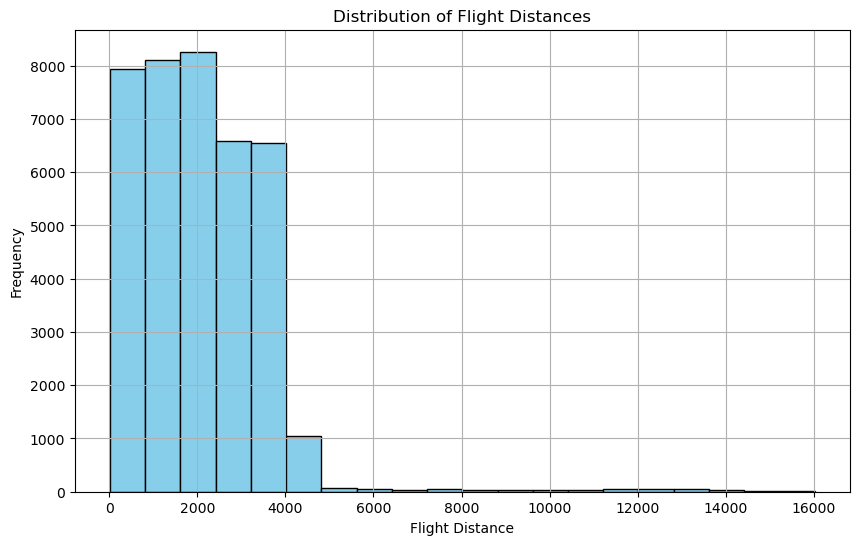

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(data['flight_distance'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Flight Distances')
plt.xlabel('Flight Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

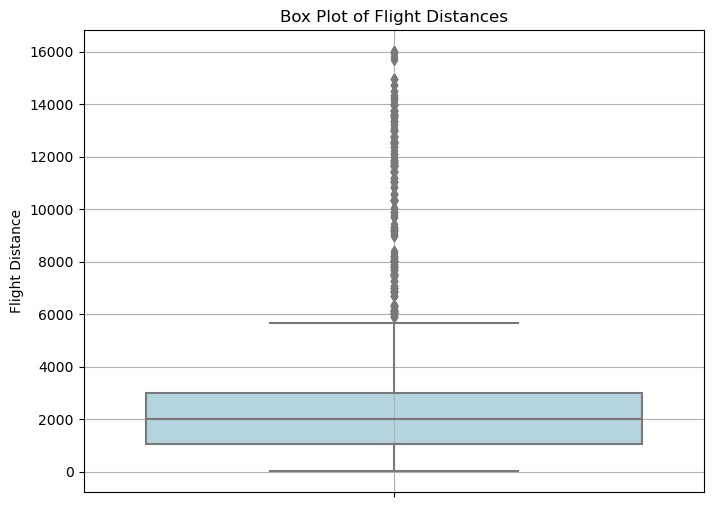

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='flight_distance', data=data, color='lightblue')
plt.title('Box Plot of Flight Distances')
plt.ylabel('Flight Distance')
plt.grid(True)
plt.show()

C:\Users\ashka\AppData\Local\Temp\ipykernel_23192\279087103.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['flight_distance'], shade=True, color='skyblue')


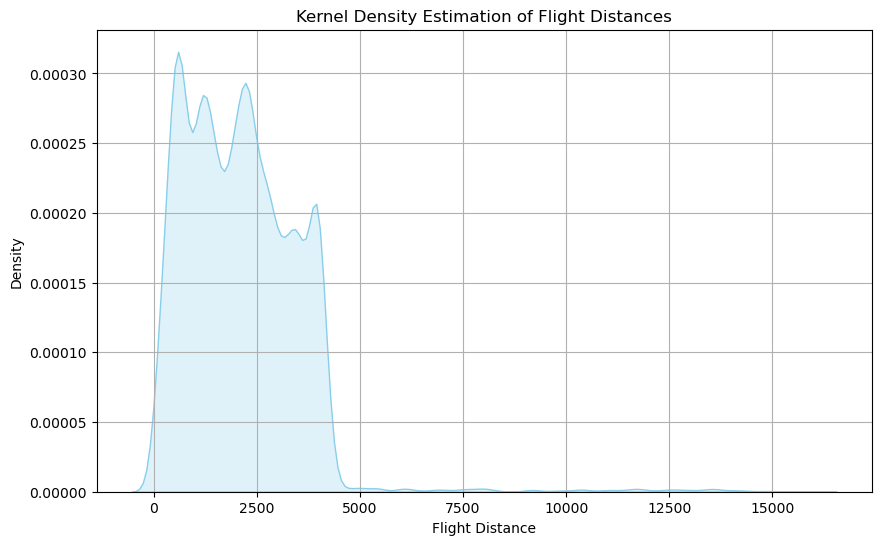

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data['flight_distance'], shade=True, color='skyblue')
plt.title('Kernel Density Estimation of Flight Distances')
plt.xlabel('Flight Distance')
plt.ylabel('Density')
plt.grid(True)
plt.show()

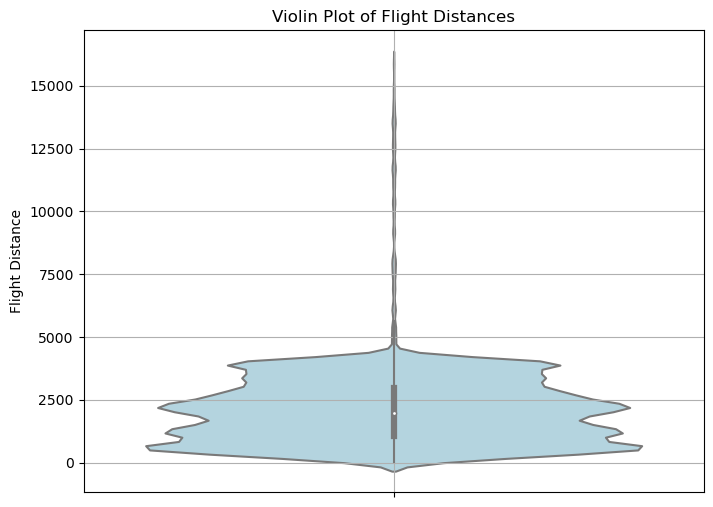

In [21]:
plt.figure(figsize=(8, 6))
sns.violinplot(y='flight_distance', data=data, color='lightblue')
plt.title('Violin Plot of Flight Distances')
plt.ylabel('Flight Distance')
plt.grid(True)
plt.show()

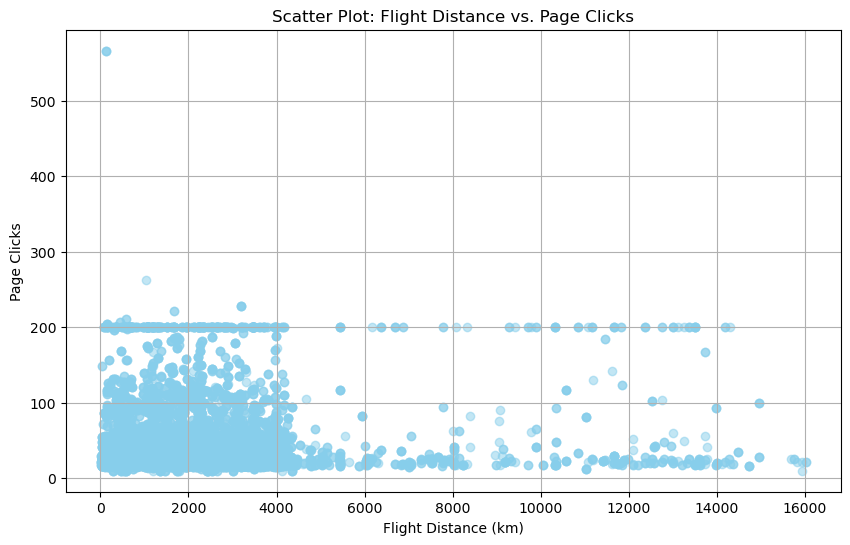

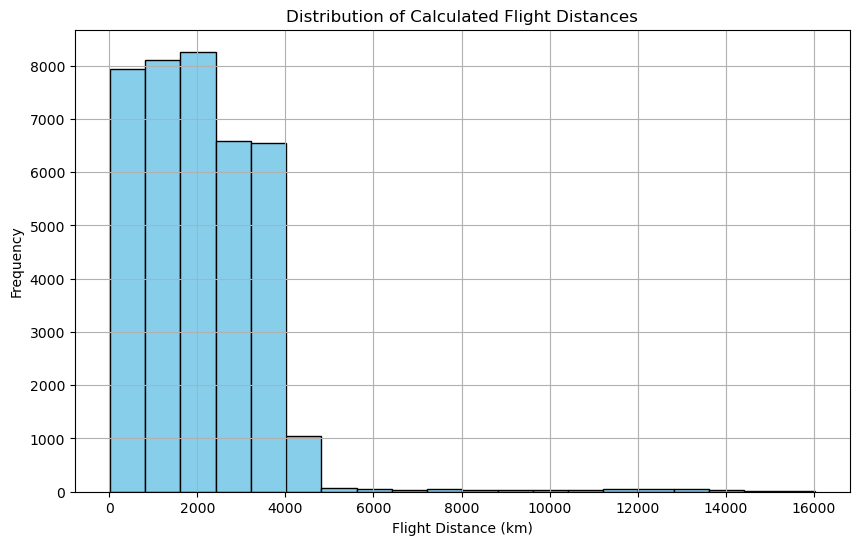

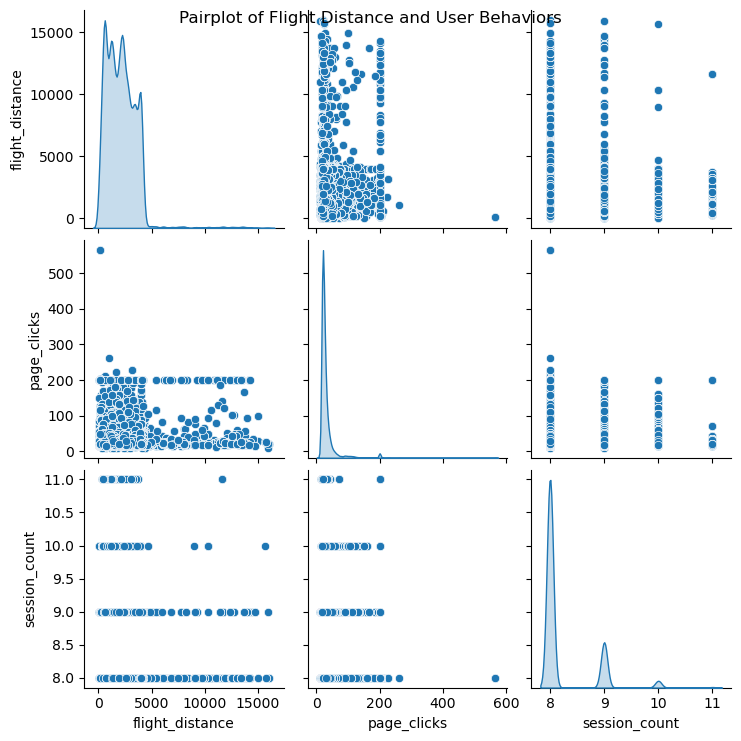

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(data['flight_distance'], data['page_clicks'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot: Flight Distance vs. Page Clicks')
plt.xlabel('Flight Distance (km)')
plt.ylabel('Page Clicks')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(data['flight_distance'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Calculated Flight Distances')
plt.xlabel('Flight Distance (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
sns.pairplot(data[['flight_distance', 'page_clicks', 'session_count']], diag_kind='kde', markers='o')
plt.suptitle('Pairplot of Flight Distance and User Behaviors')
plt.show()
